In [24]:
import os, platform, sys, h5py
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [32]:
PP = anneal.PostProcess()
master_dir = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Variable density"

def load_from_file(sub_dir):
    electrons_in_trap = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(master_dir, sub_dir), "Results.h5"), "r") as f:
        for k,step in enumerate(f.keys()):
            electrons_in_trap.append(f[step+"/electrons_in_trap"][()])
            energy.append(f[step+"/energy"][()])

            if k == 0: 
                coefficients = f[step+"/potential_coefficients"][()]
                N_electrons = np.int(len(f[step+"/electron_initial_coordinates"])/2.)
                ns_init = PP.get_electron_density(f[step+"/electron_final_coordinates"][()])
            else:
                coefficients = np.vstack((coefficients, f[step+"/potential_coefficients"][()]))
                
    return coefficients, electrons_in_trap, energy, ns_init

In [73]:
sub_dir = "161101_20_electrons"
coefficients, electrons_in_trap, energy, ns_init = load_from_file(sub_dir)
Vtrap = coefficients[:,1]

The electron density in the figure above is 1.926e+12 m^-2


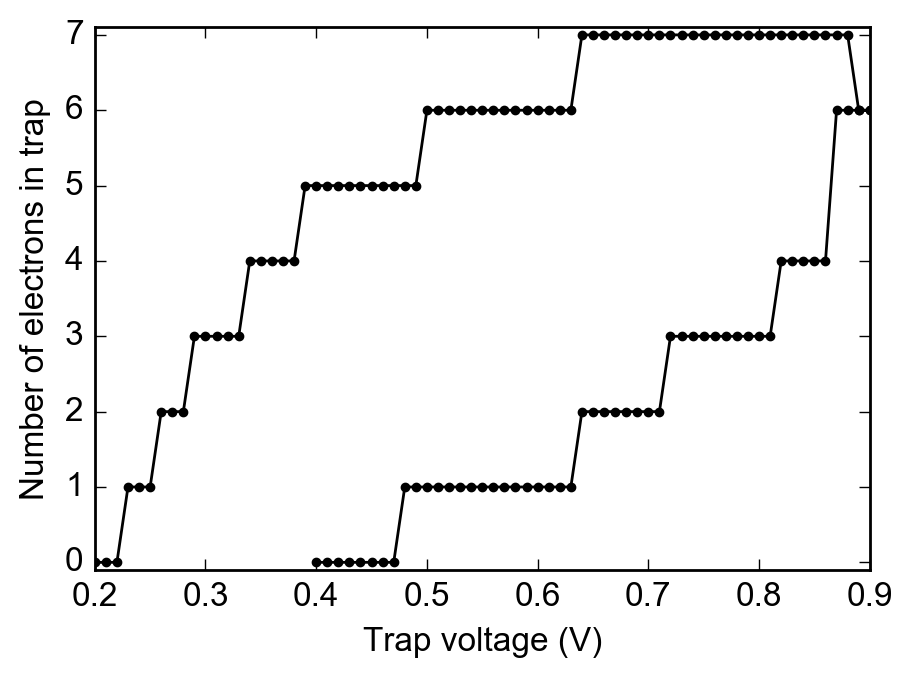

In [74]:
fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(12)
plt.plot(Vtrap, electrons_in_trap, '.-k')
plt.ylabel("Number of electrons in trap")
plt.xlabel("Trap voltage (V)")
plt.ylim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

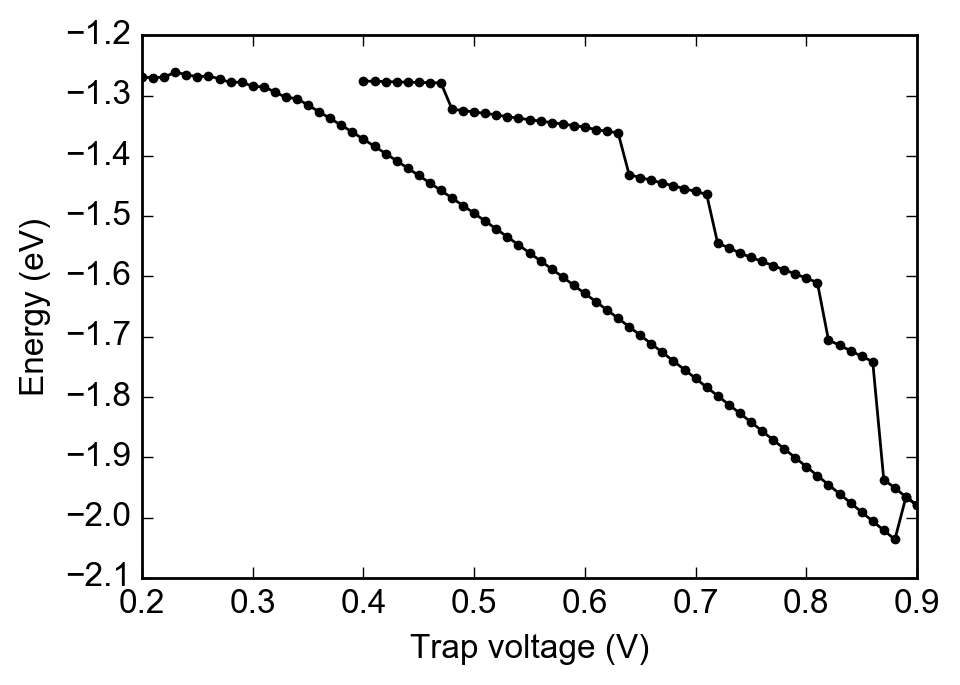

In [75]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(Vtrap, energy, '.-k')
plt.ylabel("Energy (eV)")
plt.xlabel("Trap voltage (V)")
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

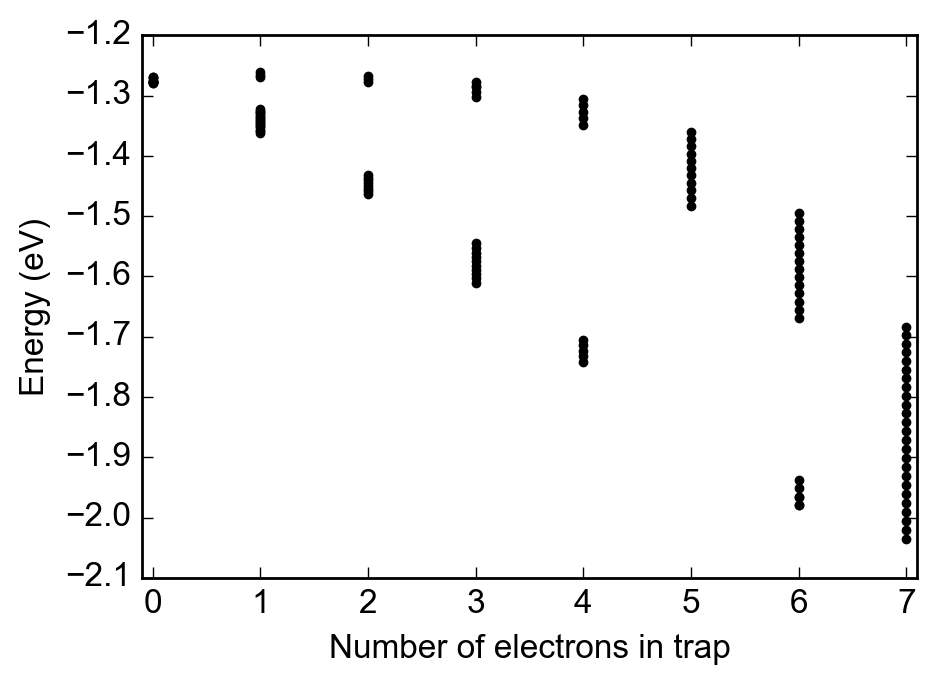

In [76]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(electrons_in_trap, energy, '.k')
plt.ylabel("Energy (eV)")
plt.xlabel("Number of electrons in trap")
plt.xlim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))